**import**

In [ ]:
# Import Moudles and Packages
import gc
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import time
import random

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["axes.grid"]=False

# Import pytorch modules
import torch
import torch.nn as nn
from torch.utils import data as D

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler
from madgrad import MADGRAD

import natsort

import gc
import torch

from mpl_toolkits.axes_grid1 import ImageGrid
from torchsummary import summary
gc.collect()
torch.cuda.empty_cache()

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

print("__Import modules and packages__\n")
print("| Pytorch version: {}".format(torch.__version__))
print("| GPU: {}".format(torch.cuda.is_available()))
print("| Device : ",device)
print("| Device name: ", torch.cuda.get_device_name(0))
print("| Device count: ", torch.cuda.device_count())

**model**

In [ ]:
from src.models import resnet, xception
model = xception.XceptionNet(num_classes=54)
model.eval()
model = model.to(device)


In [ ]:
import src.dataset.kface_dataset as K
import src.dataset.kface_transform_A as A

**dataset**

In [ ]:
import src.config as C
k_dataset_train = K.kfacedataset(
    image_list=C.IMAGE_LIST,
    label_list=C.LABEL_LIST,
    type="train",
    transform=A.get_augmentation(data_type="train")
    )

k_dataset_valid = K.kfacedataset(
    image_list=C.IMAGE_LIST,
    label_list=C.LABEL_LIST,
    type="valid",
    transform=A.get_augmentation(data_type="valid")
    )

**dataloader**

In [ ]:
train_dataset, _ = D.random_split(k_dataset_train, [C.LEN_TRAIN_SET, C.LEN_VALID_SET])
_, valid_dataset = D.random_split(k_dataset_valid, [C.LEN_TRAIN_SET, C.LEN_VALID_SET])

train_loader = D.DataLoader(
    train_dataset, batch_size=C.BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = D.DataLoader(
    valid_dataset, batch_size=C.BATCH_SIZE*2, shuffle=False, num_workers=4)

print(f'{C.LEN_TRAIN_SET} images for training')
print(f'{C.LEN_VALID_SET} images for validating')

**visualization**

In [ ]:
from src.utils.visualize import visualize_image, visualize_batch

image1, landmarks1 = train_dataset[64]
print(image1.shape)
visualize_image(image1, landmarks1)

image2, landmarks2 = train_dataset[64]
visualize_image(image2, landmarks2)

image3, landmarks3 = train_dataset[64]
visualize_image(image3, landmarks3)

In [ ]:
for x, y in train_loader:
    break

print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

for x, y in valid_loader:
    break

print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

In [ ]:
visualize_batch(x[:16], y[:16], shape = (4, 4), size = 16, title = 'Training Batch Samples')

**loss and optimizer**

In [ ]:
import torch.optim as optim
objective = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00002)

**define validation function**

In [ ]:
from tqdm import tqdm
model.eval()
@torch.no_grad()
def validate(save = None):
    cum_loss = 0.0

    for features, labels in tqdm(valid_loader, desc = 'Validating', ncols = 600):
        features = features.to(device)
        labels = labels.to(device)
        
        outputs = model(features)
        
        loss = objective(outputs, labels)
        cum_loss += loss.item()

        break
        
    visualize_batch(features[:8].cpu(), outputs[:8].cpu(),
                    shape = (2, 4), size = 16, title = 'Validation sample predictions', save = save)

    return cum_loss/len(valid_loader)

validate()

In [ ]:
from pathlib import Path
pretrained_model = '/home/ubuntu/workspace/FLD-scratch/src/pretrained_model/0624/xcep_27pt_50epoch_drop07.pt'
model_name = Path(pretrained_model).stem
model = xception.XceptionNet(num_classes=54)
model.eval()

if pretrained_model:
    state_dict = torch.load(pretrained_model,map_location='cpu')
    model.load_state_dict(state_dict)

model = model.to(device)

print(model.load_state_dict(state_dict))

validate()

In [ ]:
if os.path.isdir('kface_progress'):
    !rm -rf progress
os.mkdir('kface_progress')

Validating:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/3 [00:00<?, ?it/s]


Validation sample predictions


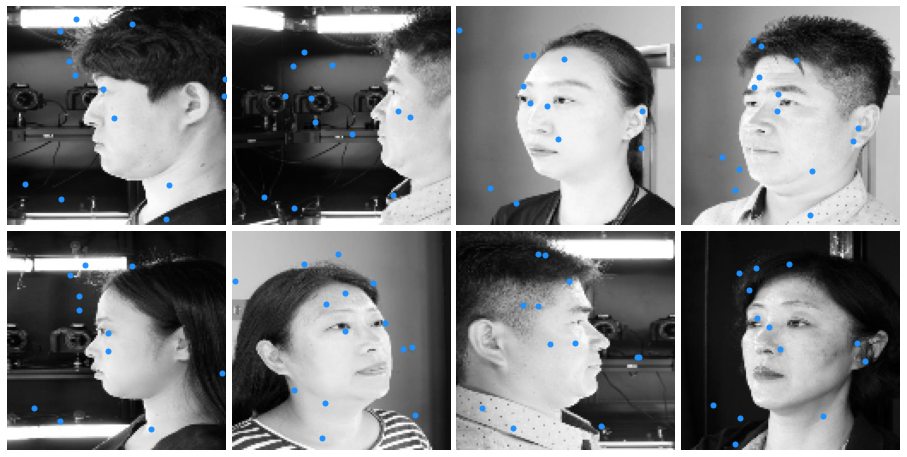

Epoch(93/100) -> Training Loss: 0.27307953 | Validation Loss: 0.08245398


Validating:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/3 [00:00<?, ?it/s]


Validation sample predictions


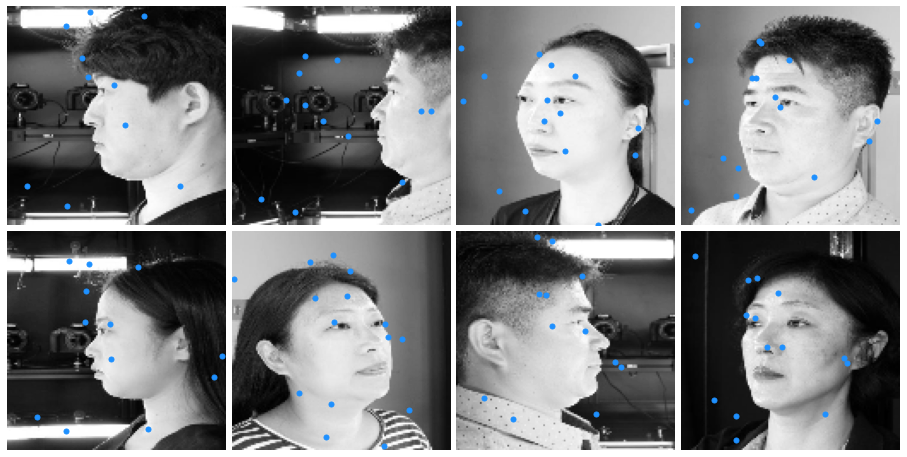

Epoch(94/100) -> Training Loss: 0.24215612 | Validation Loss: 0.08238321


Validating:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/3 [00:00<?, ?it/s]


Validation sample predictions


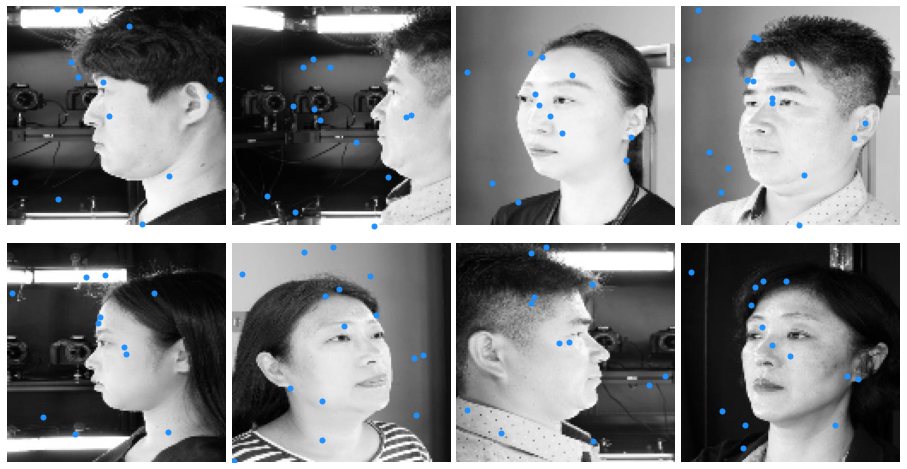

Epoch(95/100) -> Training Loss: 0.26148685 | Validation Loss: 0.08690864


Validating:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/3 [00:00<?, ?it/s]


Validation sample predictions


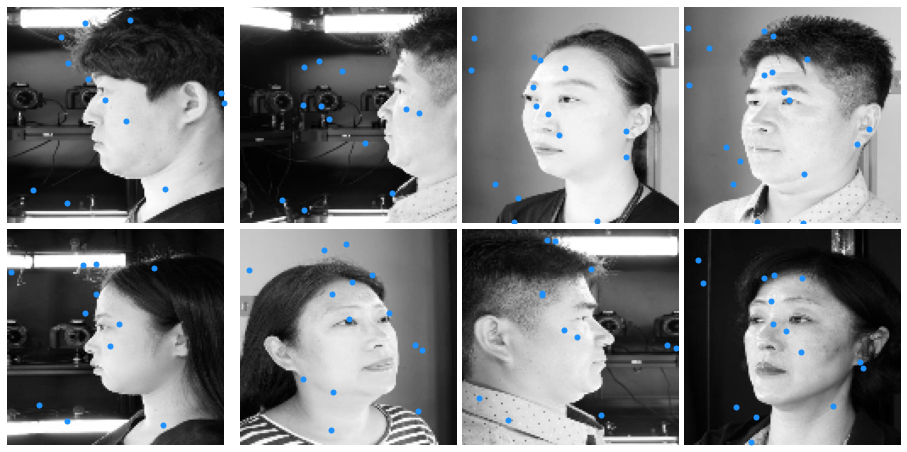

Epoch(96/100) -> Training Loss: 0.26152239 | Validation Loss: 0.08183402


Validating:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/3 [00:00<?, ?it/s]


Validation sample predictions


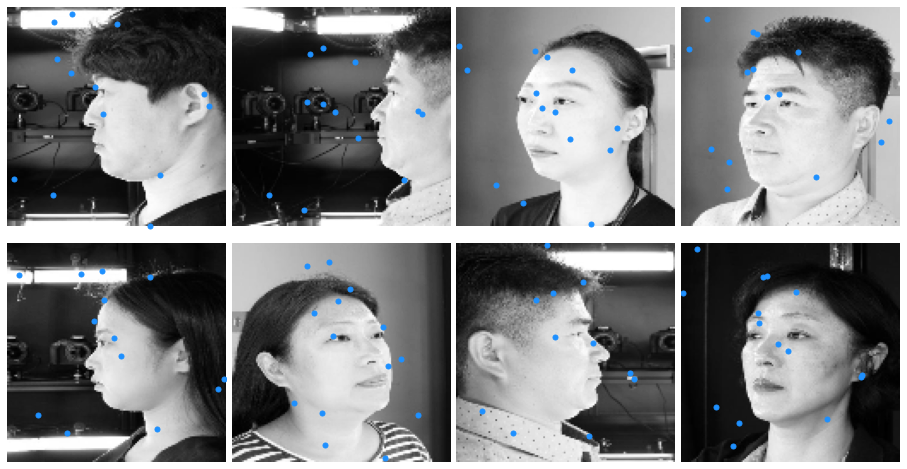

Epoch(97/100) -> Training Loss: 0.26108699 | Validation Loss: 0.08659560


Validating:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/3 [00:00<?, ?it/s]


Validation sample predictions


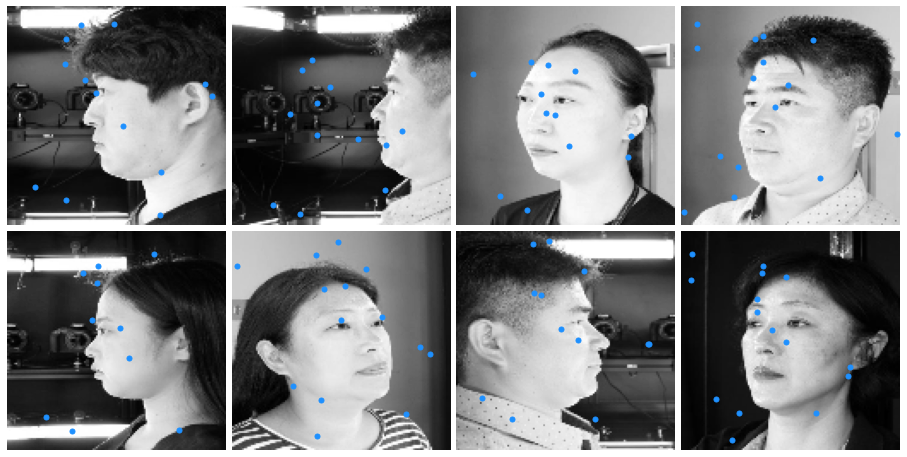

Epoch(98/100) -> Training Loss: 0.25291747 | Validation Loss: 0.08247173


Validating:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/3 [00:00<?, ?it/s]


Validation sample predictions


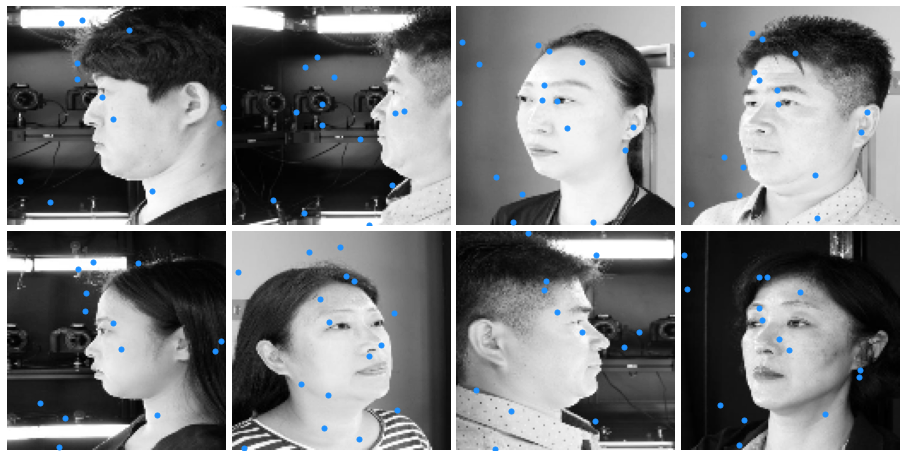

Epoch(99/100) -> Training Loss: 0.26961079 | Validation Loss: 0.08318493


Validating:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/3 [00:00<?, ?it/s]


Validation sample predictions


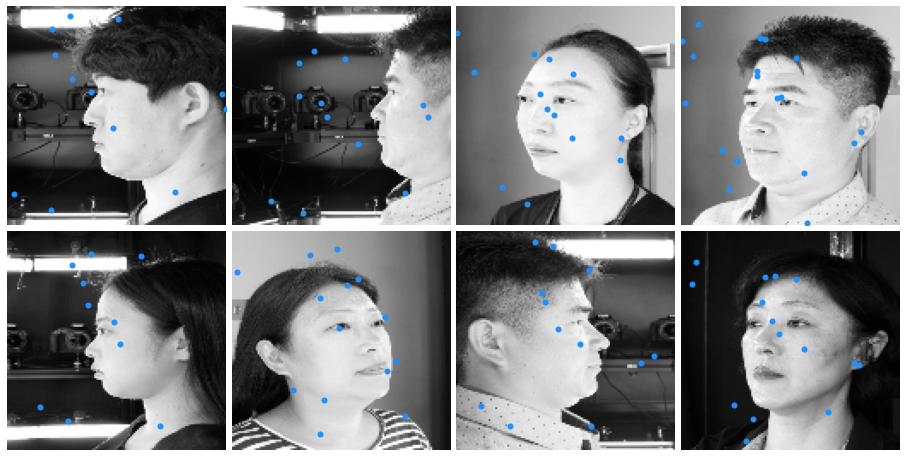

Epoch(100/100) -> Training Loss: 0.25856954 | Validation Loss: 0.08405131


: 

In [14]:
epochs = 100
batches = len(train_loader)
best_loss = np.inf
optimizer.zero_grad()

for epoch in range(epochs):
    cum_loss = 0.0

    model.train()
    for (features, labels) in train_loader:
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)
        
        loss = objective(outputs, labels)

        loss.backward()

        optimizer.step()
        
        optimizer.zero_grad()

        cum_loss += loss.item()
        
    val_loss = validate(os.path.join('/home/ubuntu/workspace/FLD-scratch/kface_progress',
                                     f'epoch({str(epoch + 1).zfill(len(str(epochs)))}).jpg'))

    if val_loss < best_loss:
        best_loss = val_loss
        print('Saving model....................')
        save_model = '/home/ubuntu/workspace/FLD-scratch/src/pretrained_model/0624/xcep_27pt_50epoch_drop07.pth'
        torch.save(model.state_dict(), save_model)

    print(f'Epoch({epoch + 1}/{epochs}) -> Training Loss: {cum_loss/batches:.8f} | Validation Loss: {val_loss:.8f}')